In [139]:
import yfinance as yf
import pandas as pd 
import numpy as np
from scipy.signal import filtfilt, freqz
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import plotly.express as px
import matplotlib.pyplot as plt

In [140]:
# SuperSmoother
def SuperSmoother(x,T):
    a = np.exp(-np.sqrt(2)*np.pi/T)
    b = 2*a*np.cos(np.sqrt(2)*np.pi/T)

    c2 = b
    c3 = -a*a
    c1 = 1-c2-c3

    B = np.array([0.5*c1,0.5*c1])
    A = np.array([1,-c2,-c3])

    return filtfilt(B, A, x)

# Media Movil
def SMA(close,T):
    return pd.Series(close).rolling(T).mean()

# Media Movil Volatilidad
def Vol_L(close,T,smooth,num_std = 2):
    return smooth - num_std*pd.Series(close).rolling(T).std()

def Vol_U(close,T,smooth,num_std = 2):
    return smooth + num_std*pd.Series(close).rolling(T).std()


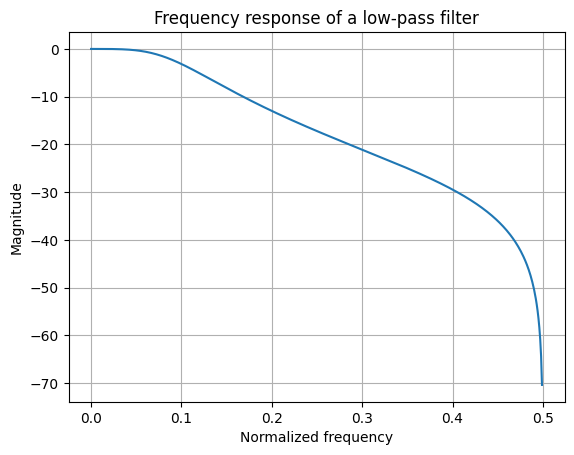

In [161]:
# Respuesta en frecuencia 
T = 10
a = np.exp(-np.sqrt(2)*np.pi/T)
b = 2*a*np.cos(np.sqrt(2)*np.pi/T)

c2 = b
c3 = -a*a
c1 = 1-c2-c3

B = np.array([0.5*c1,0.5*c1])
A = np.array([1,-c2,-c3])

w, H = freqz(B,A)
H = 20*np.log10(np.abs(H))
w = w/(2*np.pi)
fig, ax = plt.subplots()
ax.plot(w,H)
ax.set_xlabel('Normalized frequency')
ax.set_ylabel('Magnitude')
ax.set_title('Frequency response of a low-pass filter')
ax.grid(True)
plt.show()

In [ ]:
# Comparacion de medias
df = yf.download('QQQ',  start = '2010-01-01', end = '2022-01-01')
x = df['Adj Close']
T = 20; n_std = 2
df['SM'] = SuperSmoother(x,T)
df['SMA'] = SMA(x,T) 
#df['Vol_Upper_SMA'] = Vol_L(x,T,df['SMA'])
df['Vol_Upper_SM'] = Vol_U(x,T,df['SM'])
df['Vol_Lower_SM'] = Vol_L(x,T,df['SM'])
df = df.dropna()
px.line(df, y = [df['Adj Close'],df['Vol_Upper_SM'],df['Vol_Lower_SM']])

In [26]:
t1 = 10
t2 = 40

# Estrategia SuperSmoother
class strat_sm(Strategy):

    # Parametros
    T1 = t1
    T2 = t2

    def init(self):
        #Inicializa los cierres 
        close = self.data.Close
        #Inicializa los SuperSmoother con el método I (indicador)
        self.sm1 = self.I(SuperSmoother, close, self.T1)
        self.sm2 = self.I(SuperSmoother, close, self.T2)

    def next(self):

        #Compras    
        if crossover(self.sm1, self.sm2):
            self.position.close()
            self.buy()
        #Ventas
        elif crossover(self.sm2, self.sm1):
            self.position.close()
            self.sell()

In [144]:
# MEAN REVERT

# Estrategia SuperSmoother
class strat_BB_SM(Strategy):

    sl_pct = 0.015
    T = 20
    N = 2
    
    def init(self):
        #Inicializa los parametros 
        close = self.data.Close
        smooth = SuperSmoother(close,T)

        #Inicializa los SuperSmoother con el método I (indicador)
        self.upper_band = self.I(Vol_U, close, self.T, smooth, self.N)
        self.lower_band = self.I(Vol_L, close, self.T, smooth, self.N)

    def next(self):

        price = self.data.Close[-1]
        eq = self.equity

        # Compras    
        if crossover(self.lower_band,self.data.Close):
            self.position.close()
            self.buy(sl = price*(1-self.sl_pct))
        # Ventas
        elif crossover(self.data.Close,self.upper_band):
            self.position.close()
            self.sell(sl = price*(1+self.sl_pct))


# Estrategia SMA
class strat_BB_SMA(Strategy):

    T = 20
    N = 2
    sl_pct = 0.015

    def init(self):
        #Inicializa los parametros 
        close = self.data.Close
        smooth = SMA(close,T)

        #Inicializa los SuperSmoother con el método I (indicador)
        #self.sm = self.I(SuperSmoother, close, self.T)
        self.upper_band = self.I(Vol_U, close, self.T, smooth, self.N)
        self.lower_band = self.I(Vol_L, close, self.T, smooth, self.N)

    def next(self):

        price = self.data.Close[-1]

        #Compras    
        if crossover(self.lower_band,self.data.Close):
            self.position.close()
            self.buy(sl = price*(1-self.sl_pct))
        #Ventas
        elif crossover(self.data.Close,self.upper_band):
            self.position.close()
            self.sell(sl = price*(1+self.sl_pct))


In [ ]:
# Importa los datos y backtesting
xls = r'C:\Users\Usuario\Desktop\TFG\S&P 500 Companies (Standard and Poor 500).xlsx'
file_df = pd.read_excel(xls)
all_tickers = file_df['Symbol']
tickers = all_tickers[0:100]

mu = []; sigma = []; rets = []; ntrades = []

for i in range(len(tickers)):
    try:
        df = yf.download(tickers[i],  start = '2000-01-01', end = '2023-01-01')
        
        iCash = 10000
        com = 0.01

        #BACKTESTING 
        bt_sma = Backtest(df, strat_BB_SMA, cash = iCash, commission = com, exclusive_orders = True)
        bt_sm = Backtest(df, strat_BB_SM, cash = iCash, commission = com, exclusive_orders = True)

        # OUTPUTS
        output_sma = bt_sma.run()
        output_sm = bt_sm.run()
        rets.append(output_sm['# Trades'])
        mu.append(output_sm['Return (Ann.) [%]'])
        sigma.append(output_sm['Volatility (Ann.) [%]'])
        ntrades.append(output_sm['# Trades'])

    except: 
        rets.append(None); mu.append(None); sigma.append(None); ntrades.append(None)
# RESULTADOS
res = pd.DataFrame({'Ticker':tickers, 'Retornos Anualizados':mu, 'Volatilidad Anualizada':sigma, 'Numero Trades':ntrades})
mean_values = res.mean()
mean_row = pd.DataFrame(mean_values).T
res = pd.concat([res, mean_row])
res


# bt_sma.plot(plot_volume = False)
# bt_sm.plot(plot_volume = False)